In [55]:
from numpy.random import seed
seed(111)
    
from tensorflow import set_random_seed
set_random_seed(125)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

In [2]:
'''
Linear Regression README:
Modes:
1. Human Observed Dataset
2. GSC
Feature Type:
a. Feature Concat
b. Feature Subs
'''
mode = 1
subMode = 'b'

In [255]:
def create_setting_one(master_data,pos_data):
    raw_data_temp = pd.concat([pos_data.set_index('img_id_A'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    raw_data_feature_concat = pd.concat([raw_data_temp.set_index('img_id_B'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    if(np.shape(raw_data_feature_concat)[1] < 25):
        raw_data_feature_concat.drop(['Unnamed: 0'],axis=1,inplace=True)
        num_features = 9 + 1
    else:
        num_features = 512+1
    col_rename = ['img_id_B','img_id_A','target']
    for columns in range(1,len(list(raw_data_feature_concat.columns)[3:])+1):
        if(columns < num_features):
            col_rename.append("fa"+str(columns))
        else:
            col_rename.append("fb"+str(columns - num_features+1))
    raw_data_feature_concat.columns = col_rename
    col_rename.append(col_rename.pop(2))
    temp = col_rename[0]
    col_rename[0] = col_rename[1]
    col_rename[1] = temp
    raw_data_feature_concat = raw_data_feature_concat[col_rename]
    return raw_data_feature_concat

def create_setting_two(raw_data_feature_concat):
    raw_data_feature_subs = pd.concat([raw_data_feature_concat.iloc[:,0:2],raw_data_feature_concat.iloc[:,-1]],axis=1,join='inner').reset_index()
    for columns in range(1,int((len(list(raw_data_feature_concat.columns))-3)/2+1)):
        raw_data_feature_subs['fm'+str(columns)] = abs(raw_data_feature_concat['fa'+str(columns)] - raw_data_feature_concat['fb'+str(columns)])
    col_swap = list(raw_data_feature_subs.columns)[1:]
    col_swap.append(col_swap.pop(2))
    raw_data_feature_subs=raw_data_feature_subs[col_swap]
    return raw_data_feature_subs

def stratifiedSampling(data,test_split,seed):
    train,test = train_test_split(data,test_size = test_split,stratify=data[["target"]],random_state=seed)
    return train,test

def data_selection(mode,subMode):
    # GSC or HOD??
    if(mode == 1):
        hum_obs_master_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv")
        hum_obs_pos_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv")
        hum_obs_neg_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv")
        raw_pos_data = create_setting_one(hum_obs_master_data,hum_obs_pos_data)
        raw_neg_data = create_setting_one(hum_obs_master_data,hum_obs_neg_data.sample(len(hum_obs_pos_data),random_state=444))
        if(subMode == 'b'):
            raw_pos_data = create_setting_two(raw_pos_data)
            raw_neg_data = create_setting_two(raw_neg_data)
            del hum_obs_master_data,hum_obs_pos_data,hum_obs_neg_data
    elif(mode ==2):
        gsc_master_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/GSC-Features.csv")
        gsc_pos_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/same_pairs.csv")
        gsc_neg_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/diffn_pairs.csv")
                # High Memory -> NEED TO FIX
        raw_pos_data = create_setting_one(gsc_master_data,gsc_pos_data)
        raw_neg_data = create_setting_one(gsc_master_data,gsc_neg_data.sample(len(gsc_pos_data),random_state=444))
        if(subMode == 'b'):
            raw_pos_data = create_setting_two(raw_pos_data)
            raw_neg_data = create_setting_two(raw_neg_data)
            del gsc_master_data,gsc_pos_data,gsc_neg_data
    '''
    Partition Scheme
    unseenWriter = true
    default = false
    '''
    partScheme = False
    if(partScheme):
        # Unseen Writer partitions
        raw_data_feature_concat_pos[['A','A_imgNo']] = raw_data_feature_concat_pos['img_id_A'].str.extract('(\d\d\d\d)([a-z])', expand=False)
        raw_data_feature_concat_pos[['B','B_imgNo']] = raw_data_feature_concat_pos['img_id_B'].str.extract('(\d\d\d\d)([a-z])', expand=False)
        #raw_data_feature_concat['img_id_A'].str.extract('(?P<writerA>\d\d\d\d)(?P<imageNo>[abcd])', expand=False)
        raw_data_feature_concat_neg[['A','A_imgNo']] = raw_data_feature_concat_neg['img_id_A'].str.extract('(\d\d\d\d)([a-z])', expand=False)
        raw_data_feature_concat_neg[['B','B_imgNo']] = raw_data_feature_concat_neg['img_id_B'].str.extract('(\d\d\d\d)([a-z])', expand=False)
        data = pd.concat([raw_pos_data,raw_neg_data],ignore_index=True)
    else:
        data = pd.concat([raw_pos_data,raw_neg_data],ignore_index=True)
    data = data.iloc[:,2:np.shape(data)[1]]
    
    data = data.sample(frac=1,random_state=44)
    
    if(mode == 1):
        train,test = stratifiedSampling(data,0.05,444)
    elif(mode == 2):
        train,test = stratifiedSampling(data,0.1,444)
    
    return train,test

In [256]:
train,test = data_selection(1,"a")

In [257]:
def get_model():
    input_size = len(train.columns)-1
    drop_out = 0.5
    first_dense_layer_nodes  = 256
    second_dense_layer_nodes = 128
    third_dense_layer_nodes = 64
    final_dense_layer_nodes = 2
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('relu'))
    
    # Why dropout?
    # Avoids the model being overfitted for the training data such that it fails to generalize for new 
    # incidences.
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('relu'))
    
    model.add(Dense(final_dense_layer_nodes))
    model.add(Activation('softmax'))
    # Why Softmax?
    # Since this is a multi class classification problem, for the last output layer we need to translate the continous signal 
    # into a discrete signal which will give us the classes. The softmax activation converts a vector of arbitary
    # real values into a vector of values in a specific range from which we can get categories.
    # Important thing to note is that the predicted class will belong to only one class, therefore sum of 
    # probabalities sums to one. For Multi label problem we have to use a different activation, perhaps 
    # sigmoid.
    
    model.summary()
    
    # Why use categorical_crossentropy?
    # Here if we have to use crossentropy loss functions we have various choices such as Binary Crossentropy, categorical
    # crossentropy and Sparse Crossentropy. Here we have One-hot Encoded the input therefore we have to use categorical
    # crossentropy.
    # https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
    
    # Commented out to use metrics as categorical_accuracy for categorical data
    #model.compile(optimizer='rmsprop',
    #              loss='categorical_crossentropy',
    #              metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
    #rmsprop = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
    #model.compile(loss='categorical_crossentropy', optimizer=rmsprop,metrics=['accuracy'])
    
    #sgd = keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    adadelta = keras.optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=None, decay=0)
    
    model.compile(loss='binary_crossentropy', optimizer=adadelta,metrics=['binary_accuracy'])
    
    return model

model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 256)               4864      
_________________________________________________________________
activation_87 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_88 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_89 (Activation)   (None, 128)               0         
__________

In [258]:
def small_model():
    input_size = len(train.columns)-1
    drop_out = 0.03
    first_dense_layer_nodes  = 1024
    second_dense_layer_nodes = 32
    final_dense_layer_nodes = 2
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    # Why dropout?
    # Avoids the model being overfitted for the training data such that it fails to generalize for new 
    # incidences.
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    model.add(Dense(final_dense_layer_nodes))
    model.add(Activation('softmax'))

    
    model.summary()
    
    sgd = keras.optimizers.SGD(lr=0.3, decay=0.001, momentum=0.9, nesterov=True)
    
    model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['binary_accuracy'])
    
    return model

model = small_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 1024)              19456     
_________________________________________________________________
activation_91 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 32)                32800     
_________________________________________________________________
activation_92 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 2)                 66        
_________________________________________________________________
activation_93 (Activation)   (None, 2)                 0         
Total para

In [259]:
validation_data_split = 0.5
num_epochs = 10000
model_batch_size = 256
early_patience = 1024

earlystopping_cb = EarlyStopping(monitor='binary_accuracy', verbose=1, patience=early_patience, mode='min')

# Process Dataset
model_hist = model.fit(train.iloc[:,0:len(train.columns)-1]
                    , to_categorical(train.iloc[:,len(train.columns)-1:])
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [earlystopping_cb]
                   )

Train on 751 samples, validate on 751 samples
Epoch 1/10000
751/751 [==============================] - 2s 2ms/step - loss: 0.6982 - binary_accuracy: 0.5366 - val_loss: 0.6979 - val_binary_accuracy: 0.5073
Epoch 2/10000
751/751 [==============================] - 0s 104us/step - loss: 0.6903 - binary_accuracy: 0.5233 - val_loss: 0.6927 - val_binary_accuracy: 0.5113
Epoch 3/10000
751/751 [==============================] - 0s 87us/step - loss: 0.6757 - binary_accuracy: 0.5832 - val_loss: 0.6965 - val_binary_accuracy: 0.5246
Epoch 4/10000
751/751 [==============================] - 0s 99us/step - loss: 0.6746 - binary_accuracy: 0.5846 - val_loss: 0.7007 - val_binary_accuracy: 0.5233
Epoch 5/10000
751/751 [==============================] - 0s 117us/step - loss: 0.6655 - binary_accuracy: 0.5872 - val_loss: 0.7034 - val_binary_accuracy: 0.5020
Epoch 6/10000
751/751 [==============================] - 0s 115us/step - loss: 0.6603 - binary_accuracy: 0.6099 - val_loss: 0.7066 - val_binary_accuracy:

751/751 [==============================] - 0s 91us/step - loss: 0.3415 - binary_accuracy: 0.8921 - val_loss: 0.8907 - val_binary_accuracy: 0.5087
Epoch 52/10000
751/751 [==============================] - 0s 114us/step - loss: 0.3379 - binary_accuracy: 0.8881 - val_loss: 0.9324 - val_binary_accuracy: 0.4874
Epoch 53/10000
751/751 [==============================] - 0s 92us/step - loss: 0.3337 - binary_accuracy: 0.8908 - val_loss: 0.9489 - val_binary_accuracy: 0.5180
Epoch 54/10000
751/751 [==============================] - 0s 97us/step - loss: 0.3410 - binary_accuracy: 0.8788 - val_loss: 0.9392 - val_binary_accuracy: 0.4847
Epoch 55/10000
751/751 [==============================] - 0s 102us/step - loss: 0.3176 - binary_accuracy: 0.8961 - val_loss: 0.9393 - val_binary_accuracy: 0.5087
Epoch 56/10000
751/751 [==============================] - 0s 93us/step - loss: 0.3163 - binary_accuracy: 0.9055 - val_loss: 0.9550 - val_binary_accuracy: 0.4980
Epoch 57/10000
751/751 [=======================

Epoch 102/10000
751/751 [==============================] - 0s 93us/step - loss: 0.1029 - binary_accuracy: 0.9947 - val_loss: 1.3238 - val_binary_accuracy: 0.4860
Epoch 103/10000
751/751 [==============================] - 0s 88us/step - loss: 0.1051 - binary_accuracy: 0.9893 - val_loss: 1.3380 - val_binary_accuracy: 0.5060
Epoch 104/10000
751/751 [==============================] - 0s 83us/step - loss: 0.1072 - binary_accuracy: 0.9880 - val_loss: 1.3456 - val_binary_accuracy: 0.4847
Epoch 105/10000
751/751 [==============================] - 0s 75us/step - loss: 0.1085 - binary_accuracy: 0.9814 - val_loss: 1.3295 - val_binary_accuracy: 0.5060
Epoch 106/10000
751/751 [==============================] - 0s 80us/step - loss: 0.1020 - binary_accuracy: 0.9854 - val_loss: 1.3179 - val_binary_accuracy: 0.5033
Epoch 107/10000
751/751 [==============================] - 0s 81us/step - loss: 0.0958 - binary_accuracy: 0.9933 - val_loss: 1.3356 - val_binary_accuracy: 0.5007
Epoch 108/10000
751/751 [===

751/751 [==============================] - 0s 103us/step - loss: 0.0324 - binary_accuracy: 1.0000 - val_loss: 1.7209 - val_binary_accuracy: 0.4967
Epoch 153/10000
751/751 [==============================] - 0s 107us/step - loss: 0.0327 - binary_accuracy: 1.0000 - val_loss: 1.7249 - val_binary_accuracy: 0.4913
Epoch 154/10000
751/751 [==============================] - 0s 122us/step - loss: 0.0322 - binary_accuracy: 1.0000 - val_loss: 1.7314 - val_binary_accuracy: 0.4900
Epoch 155/10000
751/751 [==============================] - 0s 103us/step - loss: 0.0314 - binary_accuracy: 1.0000 - val_loss: 1.7509 - val_binary_accuracy: 0.4913
Epoch 156/10000
751/751 [==============================] - 0s 109us/step - loss: 0.0337 - binary_accuracy: 1.0000 - val_loss: 1.7449 - val_binary_accuracy: 0.4980
Epoch 157/10000
751/751 [==============================] - 0s 112us/step - loss: 0.0292 - binary_accuracy: 1.0000 - val_loss: 1.7501 - val_binary_accuracy: 0.4967
Epoch 158/10000
751/751 [=============

751/751 [==============================] - 0s 145us/step - loss: 0.0158 - binary_accuracy: 1.0000 - val_loss: 2.0258 - val_binary_accuracy: 0.4940
Epoch 203/10000
751/751 [==============================] - 0s 123us/step - loss: 0.0130 - binary_accuracy: 1.0000 - val_loss: 2.0658 - val_binary_accuracy: 0.4980
Epoch 204/10000
751/751 [==============================] - 0s 101us/step - loss: 0.0142 - binary_accuracy: 1.0000 - val_loss: 2.0819 - val_binary_accuracy: 0.4927
Epoch 205/10000
751/751 [==============================] - 0s 104us/step - loss: 0.0142 - binary_accuracy: 1.0000 - val_loss: 2.0535 - val_binary_accuracy: 0.4993
Epoch 206/10000
751/751 [==============================] - 0s 179us/step - loss: 0.0129 - binary_accuracy: 1.0000 - val_loss: 2.0418 - val_binary_accuracy: 0.4967
Epoch 207/10000
751/751 [==============================] - 0s 157us/step - loss: 0.0139 - binary_accuracy: 1.0000 - val_loss: 2.0633 - val_binary_accuracy: 0.4927
Epoch 208/10000
751/751 [=============

751/751 [==============================] - 0s 80us/step - loss: 0.0090 - binary_accuracy: 1.0000 - val_loss: 2.2971 - val_binary_accuracy: 0.4940
Epoch 253/10000
751/751 [==============================] - 0s 81us/step - loss: 0.0084 - binary_accuracy: 1.0000 - val_loss: 2.2928 - val_binary_accuracy: 0.4874
Epoch 254/10000
751/751 [==============================] - 0s 74us/step - loss: 0.0087 - binary_accuracy: 1.0000 - val_loss: 2.2990 - val_binary_accuracy: 0.5033
Epoch 255/10000
751/751 [==============================] - 0s 75us/step - loss: 0.0078 - binary_accuracy: 1.0000 - val_loss: 2.3036 - val_binary_accuracy: 0.5020
Epoch 256/10000
751/751 [==============================] - 0s 70us/step - loss: 0.0081 - binary_accuracy: 1.0000 - val_loss: 2.3003 - val_binary_accuracy: 0.4980
Epoch 257/10000
751/751 [==============================] - 0s 75us/step - loss: 0.0083 - binary_accuracy: 1.0000 - val_loss: 2.3020 - val_binary_accuracy: 0.4900
Epoch 258/10000
751/751 [===================

751/751 [==============================] - 0s 93us/step - loss: 0.0047 - binary_accuracy: 1.0000 - val_loss: 2.4866 - val_binary_accuracy: 0.4967
Epoch 303/10000
751/751 [==============================] - 0s 107us/step - loss: 0.0047 - binary_accuracy: 1.0000 - val_loss: 2.4795 - val_binary_accuracy: 0.4953
Epoch 304/10000
751/751 [==============================] - 0s 83us/step - loss: 0.0041 - binary_accuracy: 1.0000 - val_loss: 2.4759 - val_binary_accuracy: 0.4980
Epoch 305/10000
751/751 [==============================] - 0s 79us/step - loss: 0.0046 - binary_accuracy: 1.0000 - val_loss: 2.4735 - val_binary_accuracy: 0.4980
Epoch 306/10000
751/751 [==============================] - 0s 88us/step - loss: 0.0045 - binary_accuracy: 1.0000 - val_loss: 2.4846 - val_binary_accuracy: 0.4953
Epoch 307/10000
751/751 [==============================] - 0s 89us/step - loss: 0.0045 - binary_accuracy: 1.0000 - val_loss: 2.4988 - val_binary_accuracy: 0.4967
Epoch 308/10000
751/751 [==================

Epoch 353/10000
751/751 [==============================] - 0s 72us/step - loss: 0.0040 - binary_accuracy: 1.0000 - val_loss: 2.6087 - val_binary_accuracy: 0.4927
Epoch 354/10000
751/751 [==============================] - 0s 69us/step - loss: 0.0035 - binary_accuracy: 1.0000 - val_loss: 2.6191 - val_binary_accuracy: 0.4993
Epoch 355/10000
751/751 [==============================] - 0s 77us/step - loss: 0.0033 - binary_accuracy: 1.0000 - val_loss: 2.6540 - val_binary_accuracy: 0.5020
Epoch 356/10000
751/751 [==============================] - 0s 79us/step - loss: 0.0030 - binary_accuracy: 1.0000 - val_loss: 2.6695 - val_binary_accuracy: 0.4993
Epoch 357/10000
751/751 [==============================] - 0s 79us/step - loss: 0.0029 - binary_accuracy: 1.0000 - val_loss: 2.6737 - val_binary_accuracy: 0.4953
Epoch 358/10000
751/751 [==============================] - 0s 75us/step - loss: 0.0028 - binary_accuracy: 1.0000 - val_loss: 2.6709 - val_binary_accuracy: 0.4953
Epoch 359/10000
751/751 [===

751/751 [==============================] - 0s 82us/step - loss: 0.0027 - binary_accuracy: 1.0000 - val_loss: 2.8184 - val_binary_accuracy: 0.4940
Epoch 404/10000
751/751 [==============================] - 0s 84us/step - loss: 0.0021 - binary_accuracy: 1.0000 - val_loss: 2.8342 - val_binary_accuracy: 0.5007
Epoch 405/10000
751/751 [==============================] - 0s 84us/step - loss: 0.0021 - binary_accuracy: 1.0000 - val_loss: 2.8298 - val_binary_accuracy: 0.4927
Epoch 406/10000
751/751 [==============================] - 0s 80us/step - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 2.8330 - val_binary_accuracy: 0.4953
Epoch 407/10000
751/751 [==============================] - 0s 114us/step - loss: 0.0021 - binary_accuracy: 1.0000 - val_loss: 2.8271 - val_binary_accuracy: 0.4913
Epoch 408/10000
751/751 [==============================] - 0s 92us/step - loss: 0.0022 - binary_accuracy: 1.0000 - val_loss: 2.8233 - val_binary_accuracy: 0.4940
Epoch 409/10000
751/751 [==================

751/751 [==============================] - 0s 119us/step - loss: 0.0027 - binary_accuracy: 1.0000 - val_loss: 2.9263 - val_binary_accuracy: 0.4940
Epoch 454/10000
751/751 [==============================] - 0s 87us/step - loss: 0.0020 - binary_accuracy: 1.0000 - val_loss: 2.8854 - val_binary_accuracy: 0.4980
Epoch 455/10000
751/751 [==============================] - 0s 73us/step - loss: 0.0023 - binary_accuracy: 1.0000 - val_loss: 2.8810 - val_binary_accuracy: 0.4927
Epoch 456/10000
751/751 [==============================] - 0s 73us/step - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 2.8996 - val_binary_accuracy: 0.4887
Epoch 457/10000
751/751 [==============================] - 0s 74us/step - loss: 0.0020 - binary_accuracy: 1.0000 - val_loss: 2.9092 - val_binary_accuracy: 0.4913
Epoch 458/10000
751/751 [==============================] - 0s 95us/step - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 2.9283 - val_binary_accuracy: 0.4980
Epoch 459/10000
751/751 [==================

751/751 [==============================] - 0s 77us/step - loss: 0.0018 - binary_accuracy: 1.0000 - val_loss: 3.0035 - val_binary_accuracy: 0.4967
Epoch 504/10000
751/751 [==============================] - 0s 88us/step - loss: 0.0023 - binary_accuracy: 1.0000 - val_loss: 3.0093 - val_binary_accuracy: 0.5007
Epoch 505/10000
751/751 [==============================] - 0s 86us/step - loss: 0.0016 - binary_accuracy: 1.0000 - val_loss: 3.0110 - val_binary_accuracy: 0.4967
Epoch 506/10000
751/751 [==============================] - 0s 92us/step - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 3.0232 - val_binary_accuracy: 0.4953
Epoch 507/10000
751/751 [==============================] - 0s 82us/step - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 3.0205 - val_binary_accuracy: 0.5033
Epoch 508/10000
751/751 [==============================] - 0s 89us/step - loss: 0.0016 - binary_accuracy: 1.0000 - val_loss: 3.0172 - val_binary_accuracy: 0.5047
Epoch 509/10000
751/751 [===================

751/751 [==============================] - 0s 84us/step - loss: 0.0025 - binary_accuracy: 1.0000 - val_loss: 3.2050 - val_binary_accuracy: 0.5047
Epoch 554/10000
751/751 [==============================] - 0s 86us/step - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 3.1369 - val_binary_accuracy: 0.4953
Epoch 555/10000
751/751 [==============================] - 0s 83us/step - loss: 0.0022 - binary_accuracy: 1.0000 - val_loss: 3.1100 - val_binary_accuracy: 0.4993
Epoch 556/10000
751/751 [==============================] - 0s 81us/step - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 3.1342 - val_binary_accuracy: 0.5020
Epoch 557/10000
751/751 [==============================] - 0s 81us/step - loss: 0.0013 - binary_accuracy: 1.0000 - val_loss: 3.1486 - val_binary_accuracy: 0.5007
Epoch 558/10000
751/751 [==============================] - 0s 83us/step - loss: 0.0013 - binary_accuracy: 1.0000 - val_loss: 3.1618 - val_binary_accuracy: 0.4913
Epoch 559/10000
751/751 [===================

751/751 [==============================] - 0s 70us/step - loss: 0.2518 - binary_accuracy: 0.9095 - val_loss: 2.5875 - val_binary_accuracy: 0.5153
Epoch 604/10000
751/751 [==============================] - 0s 82us/step - loss: 0.2129 - binary_accuracy: 0.9041 - val_loss: 2.5106 - val_binary_accuracy: 0.5033
Epoch 605/10000
751/751 [==============================] - 0s 75us/step - loss: 0.2182 - binary_accuracy: 0.9001 - val_loss: 2.4702 - val_binary_accuracy: 0.5100
Epoch 606/10000
751/751 [==============================] - 0s 76us/step - loss: 0.1846 - binary_accuracy: 0.9241 - val_loss: 2.5460 - val_binary_accuracy: 0.5073
Epoch 607/10000
751/751 [==============================] - 0s 74us/step - loss: 0.0797 - binary_accuracy: 0.9707 - val_loss: 3.0974 - val_binary_accuracy: 0.5007
Epoch 608/10000
751/751 [==============================] - 0s 77us/step - loss: 0.1184 - binary_accuracy: 0.9521 - val_loss: 2.4327 - val_binary_accuracy: 0.4953
Epoch 609/10000
751/751 [===================

751/751 [==============================] - 0s 69us/step - loss: 0.0016 - binary_accuracy: 1.0000 - val_loss: 3.0601 - val_binary_accuracy: 0.5033
Epoch 654/10000
751/751 [==============================] - 0s 82us/step - loss: 0.0014 - binary_accuracy: 1.0000 - val_loss: 3.0666 - val_binary_accuracy: 0.5047
Epoch 655/10000
751/751 [==============================] - 0s 97us/step - loss: 0.0016 - binary_accuracy: 1.0000 - val_loss: 3.0713 - val_binary_accuracy: 0.5060
Epoch 656/10000
751/751 [==============================] - 0s 77us/step - loss: 0.0016 - binary_accuracy: 1.0000 - val_loss: 3.0746 - val_binary_accuracy: 0.5020
Epoch 657/10000
751/751 [==============================] - 0s 97us/step - loss: 0.0014 - binary_accuracy: 1.0000 - val_loss: 3.0791 - val_binary_accuracy: 0.5020
Epoch 658/10000
751/751 [==============================] - 0s 77us/step - loss: 0.0015 - binary_accuracy: 1.0000 - val_loss: 3.0819 - val_binary_accuracy: 0.5020
Epoch 659/10000
751/751 [===================

751/751 [==============================] - 0s 87us/step - loss: 9.3818e-04 - binary_accuracy: 1.0000 - val_loss: 3.2190 - val_binary_accuracy: 0.5073
Epoch 704/10000
751/751 [==============================] - 0s 74us/step - loss: 0.0011 - binary_accuracy: 1.0000 - val_loss: 3.2229 - val_binary_accuracy: 0.5060
Epoch 705/10000
751/751 [==============================] - 0s 93us/step - loss: 0.0017 - binary_accuracy: 1.0000 - val_loss: 3.2282 - val_binary_accuracy: 0.5073
Epoch 706/10000
751/751 [==============================] - 0s 75us/step - loss: 9.9889e-04 - binary_accuracy: 1.0000 - val_loss: 3.2309 - val_binary_accuracy: 0.5087
Epoch 707/10000
751/751 [==============================] - 0s 93us/step - loss: 0.0012 - binary_accuracy: 1.0000 - val_loss: 3.2352 - val_binary_accuracy: 0.5126
Epoch 708/10000
751/751 [==============================] - 0s 89us/step - loss: 0.0010 - binary_accuracy: 1.0000 - val_loss: 3.2390 - val_binary_accuracy: 0.5020
Epoch 709/10000
751/751 [===========

Epoch 753/10000
751/751 [==============================] - 0s 81us/step - loss: 8.3493e-04 - binary_accuracy: 1.0000 - val_loss: 3.3044 - val_binary_accuracy: 0.5087
Epoch 754/10000
751/751 [==============================] - 0s 80us/step - loss: 7.5802e-04 - binary_accuracy: 1.0000 - val_loss: 3.3055 - val_binary_accuracy: 0.5113
Epoch 755/10000
751/751 [==============================] - 0s 106us/step - loss: 9.1528e-04 - binary_accuracy: 1.0000 - val_loss: 3.3072 - val_binary_accuracy: 0.5113
Epoch 756/10000
751/751 [==============================] - 0s 122us/step - loss: 7.7819e-04 - binary_accuracy: 1.0000 - val_loss: 3.3106 - val_binary_accuracy: 0.5100
Epoch 757/10000
751/751 [==============================] - 0s 103us/step - loss: 7.0422e-04 - binary_accuracy: 1.0000 - val_loss: 3.3154 - val_binary_accuracy: 0.5087
Epoch 758/10000
751/751 [==============================] - 0s 80us/step - loss: 7.8989e-04 - binary_accuracy: 1.0000 - val_loss: 3.3239 - val_binary_accuracy: 0.5073
E

751/751 [==============================] - 0s 74us/step - loss: 6.1200e-04 - binary_accuracy: 1.0000 - val_loss: 3.3851 - val_binary_accuracy: 0.5047
Epoch 803/10000
751/751 [==============================] - 0s 73us/step - loss: 7.9322e-04 - binary_accuracy: 1.0000 - val_loss: 3.3865 - val_binary_accuracy: 0.5047
Epoch 804/10000
751/751 [==============================] - 0s 79us/step - loss: 4.9060e-04 - binary_accuracy: 1.0000 - val_loss: 3.3861 - val_binary_accuracy: 0.5007
Epoch 805/10000
751/751 [==============================] - 0s 75us/step - loss: 6.0064e-04 - binary_accuracy: 1.0000 - val_loss: 3.3861 - val_binary_accuracy: 0.5033
Epoch 806/10000
751/751 [==============================] - 0s 80us/step - loss: 5.6010e-04 - binary_accuracy: 1.0000 - val_loss: 3.3850 - val_binary_accuracy: 0.5033
Epoch 807/10000
751/751 [==============================] - 0s 78us/step - loss: 5.5892e-04 - binary_accuracy: 1.0000 - val_loss: 3.3844 - val_binary_accuracy: 0.4993
Epoch 808/10000
751/

751/751 [==============================] - 0s 96us/step - loss: 0.0010 - binary_accuracy: 1.0000 - val_loss: 3.4092 - val_binary_accuracy: 0.5007
Epoch 852/10000
751/751 [==============================] - 0s 112us/step - loss: 5.0896e-04 - binary_accuracy: 1.0000 - val_loss: 3.4091 - val_binary_accuracy: 0.5020
Epoch 853/10000
751/751 [==============================] - 0s 139us/step - loss: 5.5529e-04 - binary_accuracy: 1.0000 - val_loss: 3.4108 - val_binary_accuracy: 0.5020
Epoch 854/10000
751/751 [==============================] - 0s 119us/step - loss: 7.0970e-04 - binary_accuracy: 1.0000 - val_loss: 3.4136 - val_binary_accuracy: 0.5087
Epoch 855/10000
751/751 [==============================] - 0s 100us/step - loss: 4.9359e-04 - binary_accuracy: 1.0000 - val_loss: 3.4202 - val_binary_accuracy: 0.5047
Epoch 856/10000
751/751 [==============================] - 0s 105us/step - loss: 9.9378e-04 - binary_accuracy: 1.0000 - val_loss: 3.4199 - val_binary_accuracy: 0.5073
Epoch 857/10000
751

751/751 [==============================] - 0s 76us/step - loss: 9.4321e-04 - binary_accuracy: 1.0000 - val_loss: 3.4816 - val_binary_accuracy: 0.4874
Epoch 901/10000
751/751 [==============================] - 0s 76us/step - loss: 6.6074e-04 - binary_accuracy: 1.0000 - val_loss: 3.4650 - val_binary_accuracy: 0.4887
Epoch 902/10000
751/751 [==============================] - 0s 89us/step - loss: 7.2128e-04 - binary_accuracy: 1.0000 - val_loss: 3.4650 - val_binary_accuracy: 0.4913
Epoch 903/10000
751/751 [==============================] - 0s 73us/step - loss: 4.8477e-04 - binary_accuracy: 1.0000 - val_loss: 3.4734 - val_binary_accuracy: 0.4967
Epoch 904/10000
751/751 [==============================] - 0s 90us/step - loss: 8.6741e-04 - binary_accuracy: 1.0000 - val_loss: 3.4751 - val_binary_accuracy: 0.4940
Epoch 905/10000
751/751 [==============================] - 0s 99us/step - loss: 6.1471e-04 - binary_accuracy: 1.0000 - val_loss: 3.4767 - val_binary_accuracy: 0.4953
Epoch 906/10000
751/

751/751 [==============================] - 0s 88us/step - loss: 5.2556e-04 - binary_accuracy: 1.0000 - val_loss: 3.5011 - val_binary_accuracy: 0.5047
Epoch 950/10000
751/751 [==============================] - 0s 74us/step - loss: 6.0554e-04 - binary_accuracy: 1.0000 - val_loss: 3.5006 - val_binary_accuracy: 0.5100
Epoch 951/10000
751/751 [==============================] - 0s 79us/step - loss: 3.8034e-04 - binary_accuracy: 1.0000 - val_loss: 3.5029 - val_binary_accuracy: 0.5060
Epoch 952/10000
751/751 [==============================] - 0s 71us/step - loss: 3.5760e-04 - binary_accuracy: 1.0000 - val_loss: 3.5052 - val_binary_accuracy: 0.5060
Epoch 953/10000
751/751 [==============================] - 0s 74us/step - loss: 4.8800e-04 - binary_accuracy: 1.0000 - val_loss: 3.5092 - val_binary_accuracy: 0.5047
Epoch 954/10000
751/751 [==============================] - 0s 80us/step - loss: 4.5050e-04 - binary_accuracy: 1.0000 - val_loss: 3.5170 - val_binary_accuracy: 0.5020
Epoch 955/10000
751/

751/751 [==============================] - 0s 72us/step - loss: 3.7378e-04 - binary_accuracy: 1.0000 - val_loss: 3.5760 - val_binary_accuracy: 0.5033
Epoch 999/10000
751/751 [==============================] - 0s 83us/step - loss: 5.5451e-04 - binary_accuracy: 1.0000 - val_loss: 3.5728 - val_binary_accuracy: 0.5020
Epoch 1000/10000
751/751 [==============================] - 0s 76us/step - loss: 2.6947e-04 - binary_accuracy: 1.0000 - val_loss: 3.5648 - val_binary_accuracy: 0.5033
Epoch 1001/10000
751/751 [==============================] - 0s 71us/step - loss: 3.7641e-04 - binary_accuracy: 1.0000 - val_loss: 3.5612 - val_binary_accuracy: 0.5060
Epoch 1002/10000
751/751 [==============================] - 0s 73us/step - loss: 3.2956e-04 - binary_accuracy: 1.0000 - val_loss: 3.5596 - val_binary_accuracy: 0.5047
Epoch 1003/10000
751/751 [==============================] - 0s 83us/step - loss: 0.0022 - binary_accuracy: 0.9987 - val_loss: 3.5521 - val_binary_accuracy: 0.5060
Epoch 1004/10000
751

In [247]:
print("Average Categorical Accuracy Before Early Stopping: "+ str( np.mean(model_hist.history['binary_accuracy'][-early_patience:])))
print("Average Validation Accuracy Before Early Stopping: "+ str(np.mean(model_hist.history['val_binary_accuracy'][-early_patience:])))

Average Categorical Accuracy Before Early Stopping: 0.9972772543259413
Average Validation Accuracy Before Early Stopping: 0.9975997708610266


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd895d67f98>,
      dtype=object)

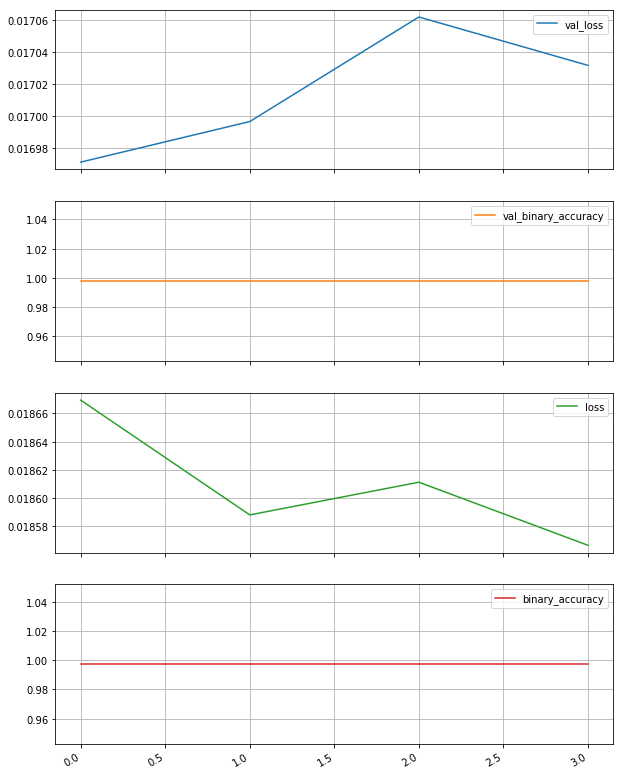

In [248]:
%matplotlib inline
df = pd.DataFrame(model_hist.history)
df.plot(subplots=True, grid=True, figsize=(10,15))


In [249]:
y = model.predict(np.array(test.iloc[:,0:len(test.columns)-1]))
predicted = np.around(y,0)

In [250]:
confusion_matrix(to_categorical(test['target'].values).argmax(axis=1), predicted.argmax(axis=1))

array([[14652,     0],
       [   40,     0]])

In [251]:
y = model.predict(np.array(train.iloc[:,0:len(train.columns)-1]))
predicted = np.around(y,0)
confusion_matrix(to_categorical(train['target'].values).argmax(axis=1), predicted.argmax(axis=1))

array([[278380,      0],
       [   751,      0]])

In [237]:
np.sum(abs(to_categorical(test['target'].values).argmax(axis=1) - predicted.argmax(axis=1)))

40

In [238]:
len(test)

80